In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier
from sklearn.feature_selection import SelectKBest, f_classif, RFE
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
# Load the dataset
file_path = '../data/CJA07.20251204134405.csv'
df = pd.read_csv(file_path)

print("Raw Data Shape:", df.shape)
print("Year Range:", df['Year'].min(), "-", df['Year'].max())
print("Unique Garda Stations:", df['Garda Station'].nunique())

Raw Data Shape: (148896, 10)
Year Range: 2003 - 2024
Unique Garda Stations: 564


# Dataset Description and Preprocessing

## Dataset
- **Source:** `CJA07.20251204134405.csv` contains annual crime statistics for Garda stations in Ireland.
- **Reference:** [data.gov.ie - Crime Data](https://data.gov.ie/dataset/crime)
- **Columns:** Key columns include `Garda Station`, `Year`, `Type of Offence`, and `VALUE` (number of incidents).
- **Granularity:** Each row represents the count of a specific offence type at a station in a given year.

## Preprocessing Steps
1. **Missing Values:**
   - Checked for missing entries in key columns.
   - Filled missing categorical values with the mode; filled missing numerical values with the median.

2. **Discretisation:**
   - Created a target variable `Safety_Level` by discretising next year's total crime into three categories: `Safe`, `Moderately Safe`, and `Unsafe` using quantile-based binning.

3. **Encoding:**
   - Categorical variables (e.g., `Type of Offence`, `Division`) were encoded using one-hot encoding or label encoding.
   - The target variable `Safety_Level` was label-encoded for classification.

4. **Outlier Handling:**
   - Outliers in crime counts were identified using boxplots and summary statistics.
   - Extreme values were either capped or left as-is, depending on their relevance.

5. **Feature Engineering:**
   - Aggregated crime counts by station and year.
   - Created lagged features to use current year's crime data to predict next year's safety level.
   - Extracted division information from station names.

6. **Scaling:**
   - Features were scaled using `StandardScaler` before model training.

## Training and Outcome Variables
- **Training Features:** Current year's crime counts for each offence type, division, and other engineered features.
- **Outcome Variable:** `Safety_Level` (Safe, Moderately Safe, Unsafe) for the next year, based on total crime.

### Summary Statistics
- **Number of samples:** See pivoted dataset shape.
- **Number of stations:** See unique station count.
- **Year range:** See min/max year.
- **Class distribution:** See value counts for `Safety_Level`.
- **Feature statistics:** Mean, median, and standard deviation for crime counts per offence type.

This preprocessing ensures the dataset is clean, encoded, and ready for classification modeling.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148896 entries, 0 to 148895
Data columns (total 10 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   STATISTIC        148896 non-null  object 
 1   STATISTIC Label  148896 non-null  object 
 2   TLIST(A1)        148896 non-null  int64  
 3   Year             148896 non-null  int64  
 4   C03037V03742     148896 non-null  int64  
 5   Garda Station    148896 non-null  object 
 6   C02480V03003     148896 non-null  int64  
 7   Type of Offence  148896 non-null  object 
 8   UNIT             148896 non-null  object 
 9   VALUE            147768 non-null  float64
dtypes: float64(1), int64(4), object(5)
memory usage: 11.4+ MB


In [5]:
# Pivot the data: Each row = (Station, Year), Columns = Offence Types
df_pivot = df.pivot_table(
    index=['Garda Station', 'Year'],
    columns='Type of Offence',
    values='VALUE',
    aggfunc='sum'
).reset_index()

# Clean column names
df_pivot.columns = [col.split('(')[0].strip() if isinstance(col, str) else col for col in df_pivot.columns]
df_pivot = df_pivot.fillna(0)

# Get offence columns
offence_cols = [col for col in df_pivot.columns if col not in ['Garda Station', 'Year']]

# Calculate total crime for each station-year
df_pivot['Total_Crime'] = df_pivot[offence_cols].sum(axis=1)

print("Pivoted Data Shape:", df_pivot.shape)
print("Offence columns:", len(offence_cols))
df_pivot.head()

Pivoted Data Shape: (12408, 15)
Offence columns: 12


,Garda Station,Year,"Attempts/threats to murder, assaults, harassments and related offences",Burglary and related offences,Controlled drug offences,Damage to property and to the environment offences,Dangerous or negligent acts,"Fraud, deception and related offences",Kidnapping and related offences,"Offences against government, justice procedures and organisation of crime",Public order and other social code offences,"Robbery, extortion and hijacking offences",Theft and related offences,Weapons and explosives offences,Total_Crime
0,"11101 Bailieboro, Cavan/Monaghan Division",2003,28.0,27.0,16.0,53.0,21.0,8.0,0.0,5.0,56.0,0.0,47.0,1.0,262.0
1,"11101 Bailieboro, Cavan/Monaghan Division",2004,45.0,13.0,7.0,42.0,22.0,9.0,0.0,9.0,89.0,1.0,34.0,1.0,272.0
2,"11101 Bailieboro, Cavan/Monaghan Division",2005,32.0,16.0,13.0,38.0,36.0,4.0,0.0,3.0,52.0,0.0,44.0,1.0,239.0
3,"11101 Bailieboro, Cavan/Monaghan Division",2006,57.0,15.0,13.0,48.0,43.0,3.0,0.0,14.0,104.0,1.0,60.0,3.0,361.0
4,"11101 Bailieboro, Cavan/Monaghan Division",2007,35.0,25.0,9.0,42.0,52.0,10.0,0.0,9.0,96.0,2.0,48.0,2.0,330.0


In [6]:
# === CREATE LAGGED FEATURES ===
# Use Year N's crime data to predict Year N+1's safety level

# Sort by station and year
df_pivot = df_pivot.sort_values(['Garda Station', 'Year'])

# Create next year's total crime (target)
df_pivot['Next_Year_Crime'] = df_pivot.groupby('Garda Station')['Total_Crime'].shift(-1)

# Remove rows where next year data is missing (last year for each station)
df_lagged = df_pivot.dropna(subset=['Next_Year_Crime']).copy()

print(f"Original samples: {len(df_pivot)}")
print(f"After lagging (losing last year per station): {len(df_lagged)}")

# Create Safety Level target based on NEXT year's crime
df_lagged['Safety_Level'] = pd.qcut(
    df_lagged['Next_Year_Crime'], 
    q=3, 
    labels=['Safe', 'Moderately Safe', 'Unsafe']
)

print("\n=== Target Variable Distribution (Next Year's Safety) ===")
print(df_lagged['Safety_Level'].value_counts())

Original samples: 12408
After lagging (losing last year per station): 11844

=== Target Variable Distribution (Next Year's Safety) ===
Safety_Level
Safe               3982
Unsafe             3946
Moderately Safe    3916
Name: count, dtype: int64


In [22]:
# Extracting and creating a new column Division from Station name
df_lagged['Division'] = df_lagged['Garda Station'].apply(
    lambda x: x.split(', ')[-1].replace(' Division', '') if ', ' in str(x) else 'Unknown'
)


NameError: name 'df_lagged' is not defined

In [8]:

print("=== Final Dataset ===")
print(f"Shape: {df_lagged.shape}")
print(f"Stations: {df_lagged['Garda Station'].nunique()}")
print(f"Years: {df_lagged['Year'].min()} - {df_lagged['Year'].max()}")
print(f"\nFeatures (current year): {offence_cols}")
print(f"Target: Next year's Safety Level")

=== Final Dataset ===
Shape: (11844, 18)
Stations: 564
Years: 2003 - 2023

Features (current year): ['Attempts/threats to murder, assaults, harassments and related offences', 'Burglary and related offences', 'Controlled drug offences', 'Damage to property and to the environment  offences', 'Dangerous or negligent acts', 'Fraud, deception and related offences', 'Kidnapping and related offences', 'Offences against government, justice procedures and organisation of crime', 'Public order and other social code offences', 'Robbery, extortion and hijacking offences', 'Theft and related offences', 'Weapons and explosives offences']
Target: Next year's Safety Level


2. Visualization

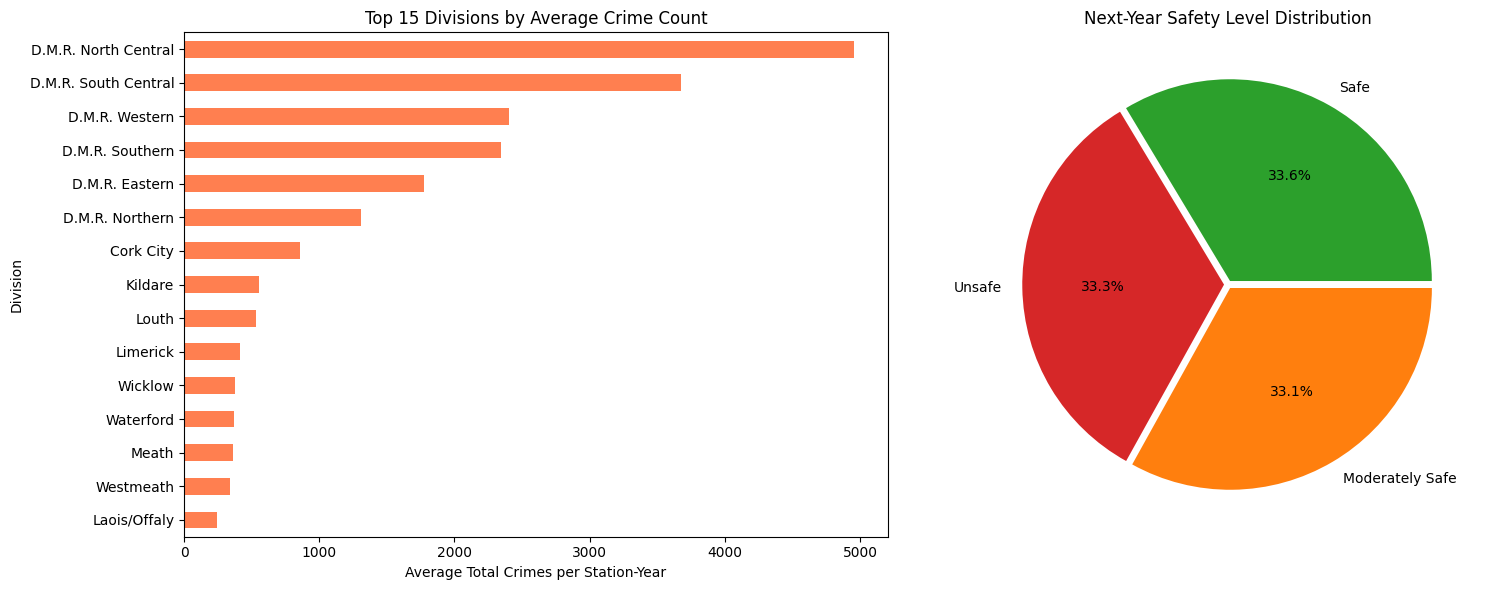

In [9]:
# Visual 1: Crime Rate Distribution by Division
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Top 15 divisions by average crime
div_crime = df_lagged.groupby('Division')['Total_Crime'].mean().sort_values(ascending=False)

ax1 = axes[0]
div_crime.head(15).plot(kind='barh', ax=ax1, color='coral')
ax1.set_xlabel('Average Total Crimes per Station-Year')
ax1.set_title('Top 15 Divisions by Average Crime Count')
ax1.invert_yaxis()

# Safety Level Distribution
ax2 = axes[1]
colors = {'Safe': '#2ca02c', 'Moderately Safe': '#ff7f0e', 'Unsafe': '#d62728'}
df_lagged['Safety_Level'].value_counts().plot(
    kind='pie', ax=ax2, autopct='%1.1f%%', 
    colors=[colors[l] for l in df_lagged['Safety_Level'].value_counts().index],
    explode=(0.02, 0.02, 0.02)
)
ax2.set_title('Next-Year Safety Level Distribution')
ax2.set_ylabel('')

plt.tight_layout()
plt.savefig('../reports/division_crime_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

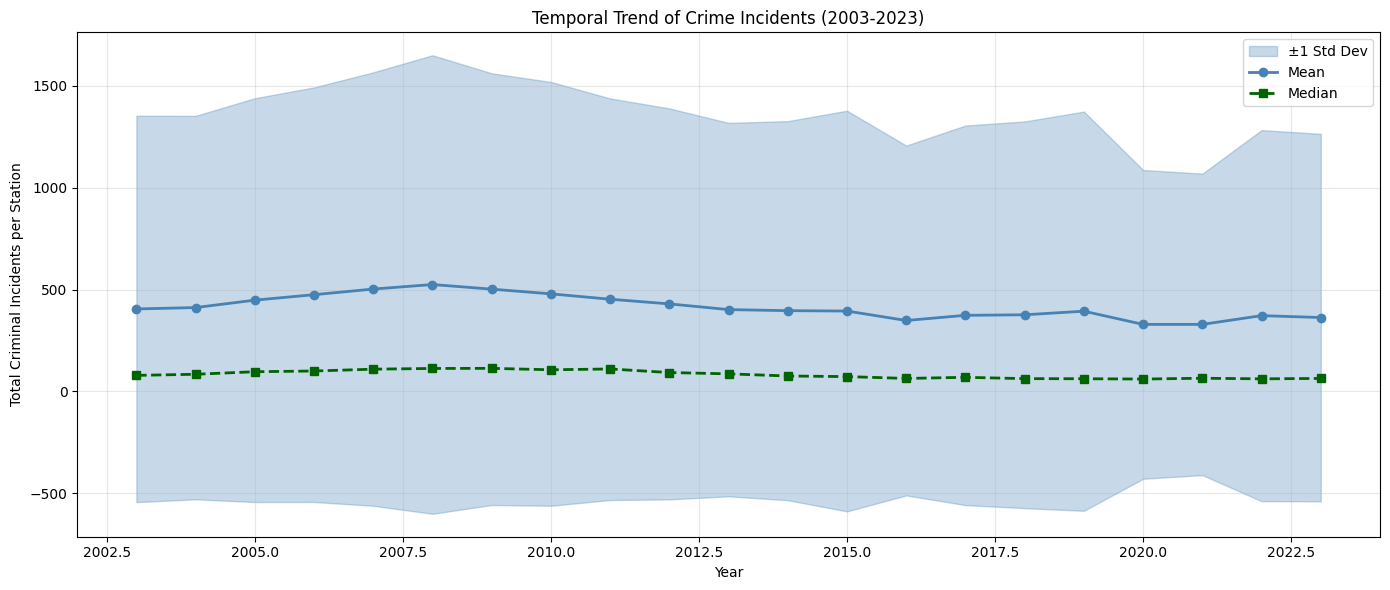

In [10]:
# Visual 2: Temporal Trends
fig, ax = plt.subplots(figsize=(14, 6))

yearly_crime = df_lagged.groupby('Year')['Total_Crime'].agg(['mean', 'median', 'std'])

ax.fill_between(yearly_crime.index, 
                yearly_crime['mean'] - yearly_crime['std'],
                yearly_crime['mean'] + yearly_crime['std'],
                alpha=0.3, color='steelblue', label='±1 Std Dev')
ax.plot(yearly_crime.index, yearly_crime['mean'], 'o-', color='steelblue', linewidth=2, label='Mean')
ax.plot(yearly_crime.index, yearly_crime['median'], 's--', color='darkgreen', linewidth=2, label='Median')

ax.set_xlabel('Year')
ax.set_ylabel('Total Criminal Incidents per Station')
ax.set_title('Temporal Trend of Crime Incidents (2003-2023)')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../reports/temporal_trend.png', dpi=150, bbox_inches='tight')
plt.show()

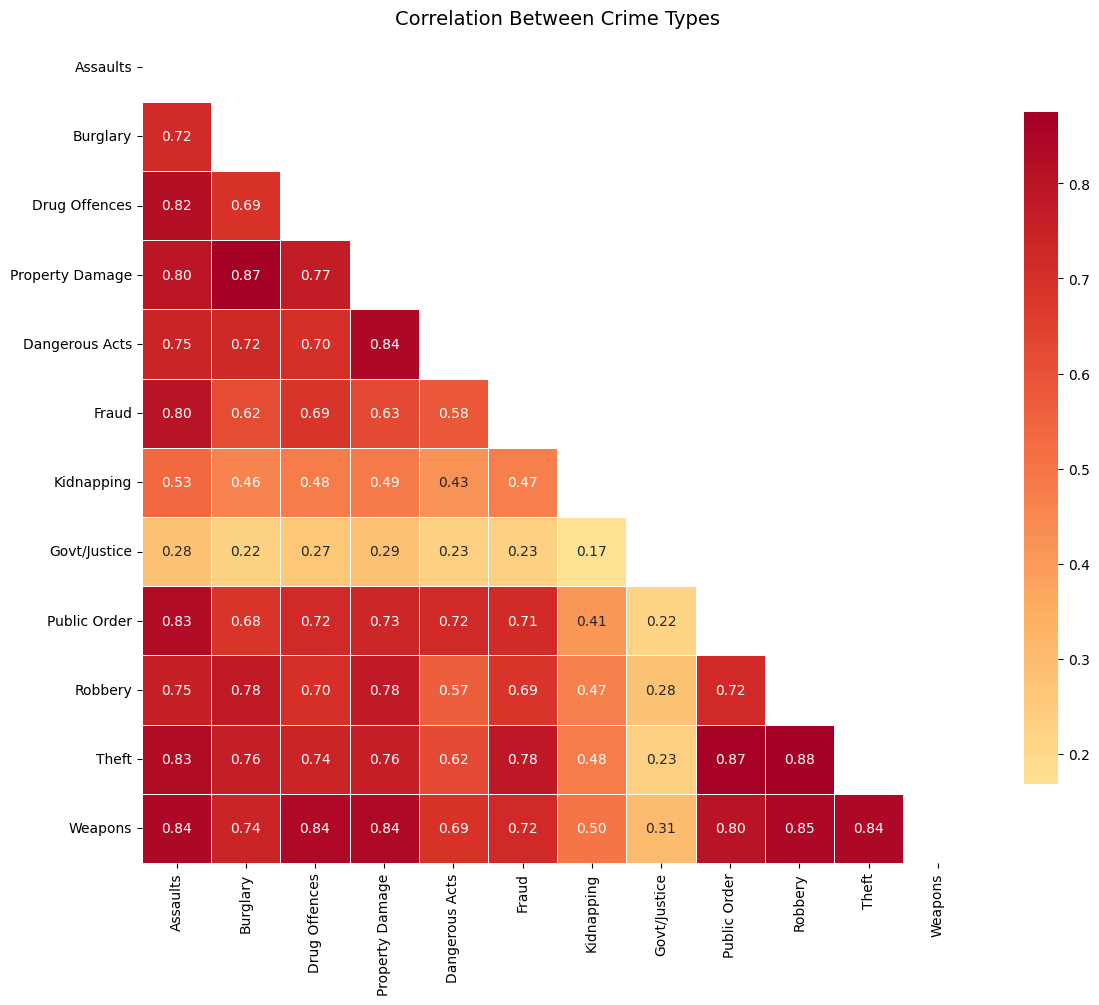

In [11]:
# Visual 3: Correlation Heatmap
plt.figure(figsize=(12, 10))

short_names = {
    'Attempts/threats to murder, assaults, harassments and related offences': 'Assaults',
    'Dangerous or negligent acts': 'Dangerous Acts',
    'Kidnapping and related offences': 'Kidnapping',
    'Robbery, extortion and hijacking offences': 'Robbery',
    'Burglary and related offences': 'Burglary',
    'Theft and related offences': 'Theft',
    'Fraud, deception and related offences': 'Fraud',
    'Controlled drug offences': 'Drug Offences',
    'Weapons and explosives offences': 'Weapons',
    'Damage to property and to the environment  offences': 'Property Damage',
    'Public order and other social code offences': 'Public Order',
    'Offences against government, justice procedures and organisation of crime': 'Govt/Justice'
}

corr_data = df_lagged[offence_cols].copy()
corr_data.columns = [short_names.get(col, col) for col in corr_data.columns]

corr_matrix = corr_data.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='RdYlBu_r',
            center=0, linewidths=0.5, square=True, cbar_kws={'shrink': 0.8})
plt.title('Correlation Between Crime Types', fontsize=14)
plt.tight_layout()
plt.savefig('../reports/crime_correlation.png', dpi=150, bbox_inches='tight')
plt.show()

In [13]:
# Prepare features (current year) and target (next year safety)
X = df_lagged[offence_cols].copy()
y = df_lagged['Safety_Level']

le = LabelEncoder()
y_encoded = le.fit_transform(y)

print("Features shape:", X.shape)
print("\nClass distribution:")
print(pd.Series(y_encoded).value_counts().sort_index())
print("\nClass mapping:", dict(zip(le.classes_, le.transform(le.classes_))))

Features shape: (11844, 12)

Class distribution:
0    3916
1    3982
2    3946
Name: count, dtype: int64

Class mapping: {'Moderately Safe': np.int64(0), 'Safe': np.int64(1), 'Unsafe': np.int64(2)}


In [14]:
# Train/Test Split (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

Training set: 9475 samples
Test set: 2369 samples


In [26]:
# Define models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

models = {
    'Baseline (Most Frequent)': LogisticRegression(),
    'Neural Network': MLPClassifier(
        hidden_layer_sizes=(64, 32), 
        max_iter=500, 
        early_stopping=True,
        random_state=42
    ),
    'Neural Network 2': MLPClassifier(
        hidden_layer_sizes=(100,64,64,32), 
        max_iter=500, 
        early_stopping=True,
        random_state=42,
        batch_size=64,
        learning_rate_init=0.001,
        alpha=0.0001
    ),
    'Decision Tree': DecisionTreeClassifier(
        max_depth=10,
        min_samples_leaf=5,
        random_state=42
    ),
    'SVM (Linear)': SVC(kernel='linear', C=1.0, random_state=42)
}

# Cross-validation evaluation
print("=" * 50)
print("MODEL PERFORMANCE (10-Fold Cross-Validation)")
print("=" * 50)

results = {}
for name, model in models.items():
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', model)
    ])
    scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='accuracy')
    results[name] = {'mean': scores.mean(), 'std': scores.std()}
    print(f"{name:30s}: {scores.mean():.4f} (+/- {scores.std():.4f})")

MODEL PERFORMANCE (10-Fold Cross-Validation)
Baseline (Most Frequent)      : 0.8805 (+/- 0.0099)
Neural Network                : 0.8820 (+/- 0.0098)
Neural Network 2              : 0.8837 (+/- 0.0078)
Decision Tree                 : 0.8525 (+/- 0.0091)
SVM (Linear)                  : 0.8806 (+/- 0.0098)


In [20]:
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import GridSearchCV
from time import time
param_grid = {
    'model__hidden_layer_sizes': [(100,), (100, 50), (150, 75), (100, 50, 25)],
    'model__alpha': [0.0001, 0.001, 0.01],
    'model__learning_rate_init': [0.001, 0.003],
    'model__batch_size': [32, 64, 128]
}

nn_pipeline = Pipeline([
    ('scaler', RobustScaler()),
    ('model', MLPClassifier(max_iter=500, random_state=42, early_stopping=True, 
                          validation_fraction=0.15, n_iter_no_change=15))
])

grid_search = GridSearchCV(
    nn_pipeline, param_grid, cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1, verbose=2
)

start_time = time()
grid_search.fit(X_train, y_train)
grid_search_time = time() - start_time

print(f"\nGridSearchCV completed in {grid_search_time/60:.2f} minutes")
print(f"\nBest Parameters:")
for param, value in grid_search.best_params_.items():
    print(f"  {param}: {value}")

Fitting 5 folds for each of 72 candidates, totalling 360 fits

GridSearchCV completed in 8.10 minutes

Best Parameters:
  model__alpha: 0.0001
  model__batch_size: 64
  model__hidden_layer_sizes: (100,)
  model__learning_rate_init: 0.001
